In [4]:
import spacy
import pandas as pd
from nltk.tokenize import word_tokenize
import itertools
import re
import numpy as np
import string
from tqdm import tqdm

In [69]:
df = pd.read_excel('training&valid.xlsx')

In [24]:
def ProTweets(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('http\S+', '', text)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: ProTweets(x))
df[['Tweet']]

In [71]:
text_ready = ' '.join(df['Tweet'])
text_ready

' Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6   Bandar Lampung  Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6   dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6   InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA  Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw TahukahKamu  Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja   InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA  Kalau di Indonesia endemik DBD tertinggi antara lain Jabar Jatim Bali DKI tapi malah 10 besar Covid Tapi kalauxe2x80xa6   Mengenal Penyakit Demam Berdarah Dengue Sejak Dini  kontribu

In [72]:
def text_to_tagReadyDF(input):
    text = input
    punctAndSpace = string.punctuation + ' '
    
    dfList = []
    for idx, t in tqdm(enumerate(text)):
        tokens = [[word_tokenize(w), ' '] for w in t.split()]
        tokens = list(itertools.chain(*list(itertools.chain(*tokens))))
        tokens = tokens[:-1]
        
        split_res = []
        for t in tokens:
                line = t.split('-')
                for i,j in enumerate(line):
                    split_res.append(j)
                    if i < len(line)-1:
                        split_res.append('-')
        
        blank = ['' if i.lower() not in list(punctAndSpace) else 'O' for i in split_res]
    
        dfTemp = pd.DataFrame([split_res, blank]).T
        dfTemp.columns = ['token_' + str(idx), 'BIO_tag_'+str(idx)]
        dfList.append(dfTemp)
    
    df = pd.concat(dfList, axis=1)

    return df

In [73]:
tagready_df = text_to_tagReadyDF([text_ready])

1it [00:03,  3.31s/it]


In [74]:
print(tagready_df.shape)
tagready_df

(19521, 2)


,token_0,BIO_tag_0
0,Ditengah,
1,,O
2,pandemi,
3,,O
4,Covid19,
...,...,...
19516,Ini,
19517,,O
19518,FaktornyannLink,
19519,,O


In [13]:
tagready_df.to_excel('data_train.xlsx', index=False)

In [15]:
def convert_to_spacyformat(df, listOfEntities):
    assert not (df.iloc[:,0].isnull().any() or df.iloc[:,1].isnull().any()), 'The dataset contains nan value.'
    
    dictTemp = {}
    dictTemp['token'] = np.array(df.iloc[:,0])
    dictTemp['BIO_tag'] = np.array(df.iloc[:,1].str.lower())
    dictTemp['indices'] = np.array([len(i) for i in dictTemp['token']])
    
    total_idx = [dictTemp['indices'][0]]
    temp = dictTemp['indices'][0]
    
    for i in range(len(dictTemp['indices'])):
        if i > 0:
            temp += dictTemp['indices'][i]
            total_idx.append(temp)
    
    dictTemp['start_idx'] = np.array([total_idx[i-1] if i > 0 else 0 for i in range(len(total_idx))])
    
    dictTemp['end_idx'] = np.array(total_idx)
    del dictTemp['indices']
    
    enti = {}
    entities = []
    text = ''.join(dictTemp['token'])
    
    listOfEntities = ['b-'+i.lower() for i in listOfEntities] + \
                     ['i-'+i.lower() for i in listOfEntities] + \
                     ['e-'+i.lower() for i in listOfEntities] + ['o']
    
    error_tag = []
    error_boolean = []
    for i in np.unique(dictTemp['BIO_tag']):
        if i in listOfEntities:
            error_boolean.append(True)
        else:
            error_boolean.append(False)
            error_tag.append(i)
    assert all(error_boolean), "Some BIO-tag not listed in listOfEntities arg. {}".format(error_tag)
    
   
    for row in range(len(dictTemp['token'])):
        if dictTemp['BIO_tag'][row] != 'o':
            entities.append((dictTemp['start_idx'][row], 
                             dictTemp['end_idx'][row], 
                             dictTemp['BIO_tag'][row]))

    
    start = []
    end = []
    BIO = []
    i = 0
    while i < len(entities):
        try:
            if entities[i][2][2:] == entities[i+1][2][2:]:
                if entities[i][2][0] == 'b':
                    start.append(entities[i][0])
                    i += 1
                    if entities[i][2][0] == 'e':
                        end.append(entities[i][1])
                        BIO.append(entities[i][2][2:])
                        i += 1
                        continue
                    elif entities[i][2][0] == 'i':
                        for j in range(i, len(entities)):
                            if entities[j][2][0] != 'e' and j < len(entities)-1:
                                continue
                            elif entities[j][2][0] == 'e':
                                end.append(entities[j][1])
                                BIO.append(entities[j][2][2:])
                                i = j+1
                                break
                            else:
                                assert 1 == 0, \
                                    "Something error in the BIO-tag you wrote. Error BIO tag: '{}'" \
                                    .format(entities[j][2])
                    elif entities[i][2][0] == 'b':
                        end.append(entities[i-1][1])
                        BIO.append(entities[i-1][2][2:])
                        continue
                        
                  
            else:

                start.append(entities[i][0])
                end.append(entities[i][1])
                BIO.append(entities[i][2][2:])
                i += 1
        except IndexError:
            start.append(entities[i][0])
            end.append(entities[i][1])
            BIO.append(entities[i][2][2:])
            i += 1

    enti['entities'] = [(i,j,k) for i,j,k in zip(start, end, BIO)]
    return [text, enti]

In [17]:
annotations = sorted(['orang',
               'lokasi',
               'organisasi',
               ])
annotations

['lokasi', 'orang', 'organisasi']

In [77]:
df_tag = pd.read_excel('data_train_tagged.xlsx')
df_tag[df_tag['BIO_tag_0'].isin(['b-lokasi', 'b-organisasi', 'b-orang'])]

,token_0,BIO_tag_0
20,di,b-lokasi
34,Bandar,b-lokasi
58,di,b-lokasi
226,di,b-lokasi
240,Jabar,b-lokasi
...,...,...
19358,Batu,b-lokasi
19370,di,b-lokasi
19496,Dikes,b-organisasi
19498,Lobar,b-lokasi


In [78]:
train_data = convert_to_spacyformat(df_tag, annotations)
train_data

['Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6 Bandar Lampung Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6 dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6 InfoKesehatan AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt INFOwargaDKI duniaWANITA Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw TahukahKamu Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja InfoKesehatan AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt INFOwargaDKI duniaWANITA Kalau di Indonesia endemik DBD tertinggi antara lain Jabar Jatim Bali DKI tapi malah 10 besar Covid Tapi kalauxe2x80xa6 Mengenal Penyakit Demam Berdarah Dengue Sejak Dini kontributormenulis InfoKeseha

In [79]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from spacy.training import Example
from spacy.tokens import Doc
import random
from matplotlib import pyplot as plt

In [80]:
def training_spacy(data, iterations):
    
    data_train = data
    nlp=spacy.blank('id')
    
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner')
    
    for _, annotations in data_train:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])
            
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        
        nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(data_train)
            losses = {}
            
            batches = minibatch(data_train, size=compounding(4.0, 64.0, 1.001))
            
            for batch in batches:
                for texts, annotations in batch:
                    doc = nlp.make_doc(texts)
                    example = Example.from_dict(doc, annotations)
                    nlp.update([example], 
                               drop=0.5, 
                               losses=losses,)
            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [81]:
model, loss = training_spacy([train_data], 100)

Starting iteration 0
{'ner': 8962.999404907227}
Starting iteration 1
{'ner': 8991.544311523438}
Starting iteration 2
{'ner': 8539.834911346436}
Starting iteration 3
{'ner': 8282.905475616455}
Starting iteration 4
{'ner': 7857.905937194824}
Starting iteration 5
{'ner': 7160.2105712890625}
Starting iteration 6
{'ner': 6093.830173492432}
Starting iteration 7
{'ner': 4897.7624435424805}
Starting iteration 8
{'ner': 3428.212390899658}
Starting iteration 9
{'ner': 2437.7331018447876}
Starting iteration 10
{'ner': 1489.680329799652}
Starting iteration 11
{'ner': 1294.8353247642517}
Starting iteration 12
{'ner': 1300.0678272247314}
Starting iteration 13
{'ner': 1273.3120132610202}
Starting iteration 14
{'ner': 1311.5742704868317}
Starting iteration 15
{'ner': 1273.9253742098808}
Starting iteration 16
{'ner': 1274.2755092978477}
Starting iteration 17
{'ner': 1270.0245666503906}
Starting iteration 18
{'ner': 1235.8078785911202}
Starting iteration 19
{'ner': 1195.2904629707336}
Starting iteration

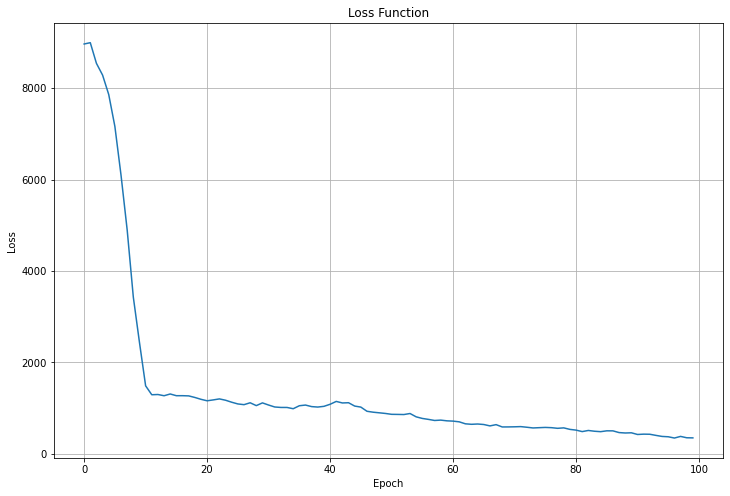

In [82]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [83]:
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: ModelNer


In [1]:
from spacy import load, displacy

In [2]:
link_to_model = "ModelNer"
loaded_model = load(link_to_model)

In [53]:
dt = pd.read_excel('data_test.xlsx')
dt['Tweet'] = dt['Tweet'].apply(lambda x: ProTweets(x))

In [54]:
test_text = ' '.join(dt['Tweet'])

In [56]:
doc = loaded_model(test_text)
displacy.render(doc, style="ent")

In [57]:
pred_value = loaded_model(test_text)

for ent in pred_value.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Babinsa 817 824 organisasi
Kelurahan Kesenden 825 843 lokasi
Dinas 867 872 lokasi
DPRD 1420 1424 organisasi
Jateng 1425 1431 lokasi
Dinas Kesehatan 1752 1767 organisasi
Kabupaten Karawang 1768 1786 lokasi
DPRD 1855 1859 organisasi
Jateng 1860 1866 lokasi
Pengurus 2040 2048 lokasi
DPC 2071 2074 organisasi
Kecamatan Denpasar 2079 2097 lokasi
Pengurus 2175 2183 lokasi
DPC 2206 2209 organisasi
Kecamatan Denpasar 2214 2232 lokasi
Kab Tabanan 2528 2539 lokasi
di Kabupaten Bandung 2708 2728 lokasi
di Sikka 3276 3284 lokasi
di Karimun 3485 3495 lokasi
Dinkes 3516 3522 organisasi
DPRD 3580 3584 organisasi
Kota Tasikmalaya 3585 3601 lokasi
di Kota Jambi 3622 3635 lokasi
di Kota Jambi 3737 3750 lokasi
di Kota Banjar Kecamatan 3830 3854 lokasi
di Kabupaten Tasik 3894 3912 lokasi
di Pekanbaru 3967 3979 lokasi
di Kota Tasikmalaya 4020 4039 lokasi
di Jawa Barat Dinkes 4050 4070 lokasi
di Tenayan 4132 4142 lokasi
Pekanbaru 4148 4157 lokasi
di Kota Tasikmalaya 4302 4321 lokasi
di Bandar Lampung 4431 44

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(pred_value, dt['BIO_tag_0']), annot=True, fmt=".0f")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [19538, 19521]